# This is a data linking tool that links stream gauge data to satellite data (DEA's Water Observations from Space data set). It generates images of water bodies according to a user-specified flow or water level range of a gauge.

Here are the necessary imports required to generate graphs and work with data.

In [1]:
#Just run this box once with 'Shift'+'Enter'. It loads all the things you need to work with the data. 
import sys
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
from matplotlib import pyplot
import datacube
from datacube.utils import geometry 
from datacube.utils.geometry import CRS
from datacube.storage import masking
from datacube.helpers import ga_pq_fuser, write_geotiff
from digitalearthau.utils import wofs_fuser
sys.path.append('../10_Scripts/')
#import DEAPlotting, DEADataHandling
import warnings
warnings.filterwarnings('ignore', module='datacube')
%load_ext autoreload
%autoreload 2

# Enter location and generate duration curve

Barmah choke: 
lat = -35.92
lon = 145.00
buffer = 10000

Colignan:
lat = -34.56709452
lon = 142.4072101
buffer = 7000

Niemur:
lat = -35.277
lon = 144.3477
buffer = 5500

Macquarie Marshes:
lat = -30.8072
lon = 147.5149
buffer = 10000

Gunbower:
lat = -35.942574
lon = 144.46466
buffer = 10000

Walkool:
lat = -35.1356
lon = 143.6823
buffer = 10000

Murray River at Boundary Bend:
lat = -34.71966901
lon = 143.1698626
buffer = 10000

Wee Waa:
lat = -30.2033
lon = 149.4361
buffer = 10000

Yarrongbilly:
lat = -35.79
lon = 148.40138889
buffer = 6000

Above are some areas in the basin. You can copy and paste these, or choose your own lat and lon in the box below. The buffer is how many meters squared around the area you want to display. You also have to have downloaded a csv file from the BoM's Water Data Online website and tell the code where abouts on your computer to get the file from. It is possible to read csv files from other sources but you will have to change the pd.read_csv( ) arguments accordingly. A flow duration curve will be generated from the csv file. This example will look at the Murray River at Boundary Bend.  

Text(0.5, 1.0, 'FDC')

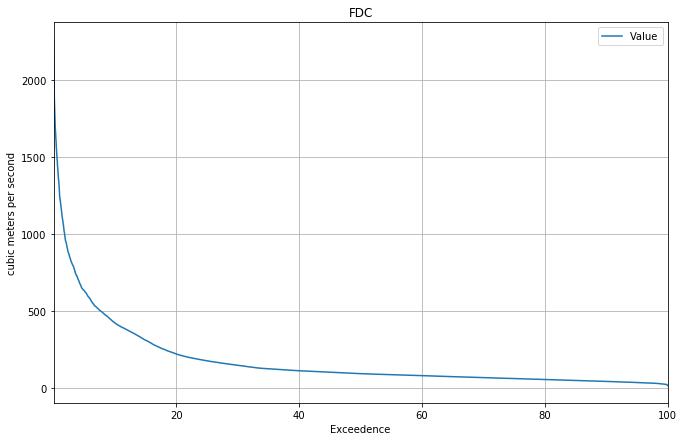

In [2]:
#What are the latitudes and longtitudes of the area you want to make a picture of?
lat = -34.71966901
lon = 143.1698626
buffer = 8000
#Where abouts is your csv file located on your computer?
csv_file_location = '/g/data/r78/kd6095/dea-notebooks/Boundary_Bend/Murray_River_Boundary_Bend.csv'

#Loading and organising guage data
gauge_data = pd.read_csv(csv_file_location,
                error_bad_lines = False, skiprows=9, escapechar='#', 
                         parse_dates=['Timestamp'], #Tells it this column is date format
                         index_col=('Timestamp'),
                        date_parser=lambda x: pd.to_datetime(x.rsplit('+', 1)[0]))
gauge_data = gauge_data.dropna()
gauge_data = gauge_data.sort_values('Value')
gauge_data['rownumber'] = np.arange(len(gauge_data))
gauge_data['Exceedence'] = (1-(gauge_data.rownumber/len(gauge_data)))*100
gauge_data = gauge_data.drop(columns='Interpolation Type')
gauge_data = gauge_data.drop(columns='Quality Code')


gauge_data.plot(x='Exceedence', y='Value', figsize=(11,7))
plt.ylabel('cubic meters per second')
plt.grid(True)
plt.title('FDC')

# Select range of flow / water level to analyse

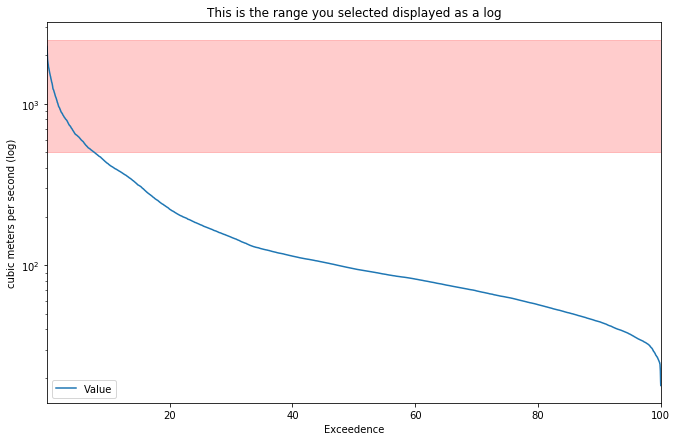

In [3]:
#What part of the Flow Duration Curve do you want to look at?
yaxis_lower_parameter = 500
yaxis_higher_parameter = 2500

#Let's look at it on a log scale
ax2 = gauge_data.plot(x='Exceedence', y='Value', figsize=(11,7)) 
ax2 = plt.axhspan(yaxis_lower_parameter, yaxis_higher_parameter, color='red', alpha=0.2)
ax2 = plt.title('This is the range you selected displayed as a log')
ax2 = plt.ylabel('cubic meters per second (log)')
ax2 = plt.xlabel('Exceedence')
ax2 = pyplot.yscale('log')

Now the code will merge the satellite data with the gauge data for the part of the duration curve you have selected. This part of the code will tell you how many passes you are about to load. I recommend loading between 50 and 300 passes. You can change the duration curve parameters to change the number of passes. This box should only take about 20secs to run as it uses a technique called Dask loading, ie it doesn't have to actually load all of the satellite data since 1988 in order to merge it with the gauge data. 

In [5]:
gauge_data_xr = gauge_data.to_xarray()

#Dask loading wofs_albers data
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),    
         'time': ('1988-01-01', '2019-08-22'), 
         'crs': 'EPSG:3577'} 
dc = datacube.Datacube(app='dc-WOfS')
wofs_albers= dc.load(product = 'wofs_albers', dask_chunks = {}, group_by='solar_day', **query)

merged_data = gauge_data_xr.interp(Timestamp=wofs_albers.time)

specified_level = merged_data.where((merged_data.Value > yaxis_lower_parameter) & 
                                    (merged_data.Value < yaxis_higher_parameter), drop=True)
date_list = specified_level.time.values

#Check how many satellite passes you are about to load (I suggest not more than 300)
specified_level.time

<xarray.DataArray 'time' (time: 92)>
array(['1989-05-30T23:43:19.500000000', '1989-07-01T23:42:40.500000000',
       '1989-07-17T23:42:19.500000000', '1989-07-24T23:48:22.500000000',
       '1989-08-09T23:48:01.500000000', '1989-09-03T23:41:19.000000000',
       '1989-09-10T23:47:14.500000000', '1989-09-19T23:40:46.500000000',
       '1989-09-26T23:46:55.500000000', '1989-10-05T23:40:36.500000000',
       '1989-10-12T23:46:27.500000000', '1990-08-12T23:41:10.500000000',
       '1990-09-06T23:34:49.500000000', '1990-09-13T23:41:02.500000000',
       '1990-09-22T23:34:47.500000000', '1990-09-29T23:40:51.500000000',
       '1990-10-08T23:34:36.500000000', '1990-10-24T23:34:32.500000000',
       '1991-10-11T23:39:06.500000000', '1991-10-27T23:39:09.500000000',
       '1992-10-20T23:42:39.500000000', '1992-11-05T23:42:23.500000000',
       '1992-11-14T23:36:02.500000000', '1992-11-30T23:36:08.500000000',
       '1993-01-01T23:36:28.500000000', '1993-01-08T23:42:45.500000000',
       '1993-0

# Load data and cloud mask

The code will now load those passes above and cloud mask them; ie it will take out any passes that were too cloudy (this is done by using inbuilt modules from the Geoscience datacube that analyse bit flags). You can see how many clear passes you get after the cloud mask. I would suggest having at least 12 passes from which to generate a water frequency image. This step should take about 2mins to run if you have around 200 passes.  

In [6]:
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer), 
         'crs': 'EPSG:3577'} 

#loop selecting data based on FDC parameters
xr_list = []
for date in date_list:
    date = str(date)  
    wofs_albers= dc.load(product = 'wofs_albers', time=date,  **query)
    xr_list.append(wofs_albers)
specified_passes = xr.concat(xr_list, dim='time')

#Cloud Mask
ClearTimesteps = []
for ix, timestep in enumerate(specified_passes.time):
    SingleTime = specified_passes.water.isel(time=ix)
    IsItCloudy = masking.make_mask(SingleTime, cloud=True)
    CountClouds = IsItCloudy.sum()   
    PercentCloudy = CountClouds.values.item()/(len(specified_passes.x)*len(specified_passes*y))*100
    IsItClearEnough = PercentCloudy <= 50  
    if IsItClearEnough:
        ClearTimesteps.append(ix)     
clear_specified_passes = specified_passes.water.isel(time = ClearTimesteps)

wet = (clear_specified_passes == 128).sum(dim='time')
dry = (clear_specified_passes == 0).sum(dim='time')
clear = wet + dry
frequency = wet / clear
frequency= frequency.fillna(0) #this is to get rid of the NAs that occur due to mountain shadows
frequency = frequency.where(frequency!=0) #This is to tell it to make areas that were dry 100% of the time white

#See how many clear passes you got to generate the image with
clear_specified_passes.time

<xarray.DataArray 'time' (time: 44)>
array(['1989-05-30T23:43:19.500000000', '1989-07-01T23:42:40.500000000',
       '1989-07-24T23:48:22.500000000', '1989-09-03T23:41:19.000000000',
       '1989-09-19T23:40:46.500000000', '1989-09-26T23:46:55.500000000',
       '1989-10-05T23:40:36.500000000', '1989-10-12T23:46:27.500000000',
       '1990-08-12T23:41:10.500000000', '1990-09-13T23:41:02.500000000',
       '1990-09-22T23:34:47.500000000', '1990-09-29T23:40:51.500000000',
       '1990-10-24T23:34:32.500000000', '1991-10-11T23:39:06.500000000',
       '1992-10-20T23:42:39.500000000', '1992-11-30T23:36:08.500000000',
       '1993-01-01T23:36:28.500000000', '1993-01-08T23:42:45.500000000',
       '1993-10-07T23:43:26.500000000', '1993-10-16T23:37:11.500000000',
       '1993-11-08T23:43:12.500000000', '1993-11-17T23:36:54.500000000',
       '1993-11-24T23:43:05.500000000', '1995-09-04T23:17:28.500000000',
       '1996-11-25T23:36:18.500000000', '1996-12-02T23:42:49.500000000',
       '2010-1

An image will now be generated from the passes indicated above. 

# Generate image of specified flow / water level range

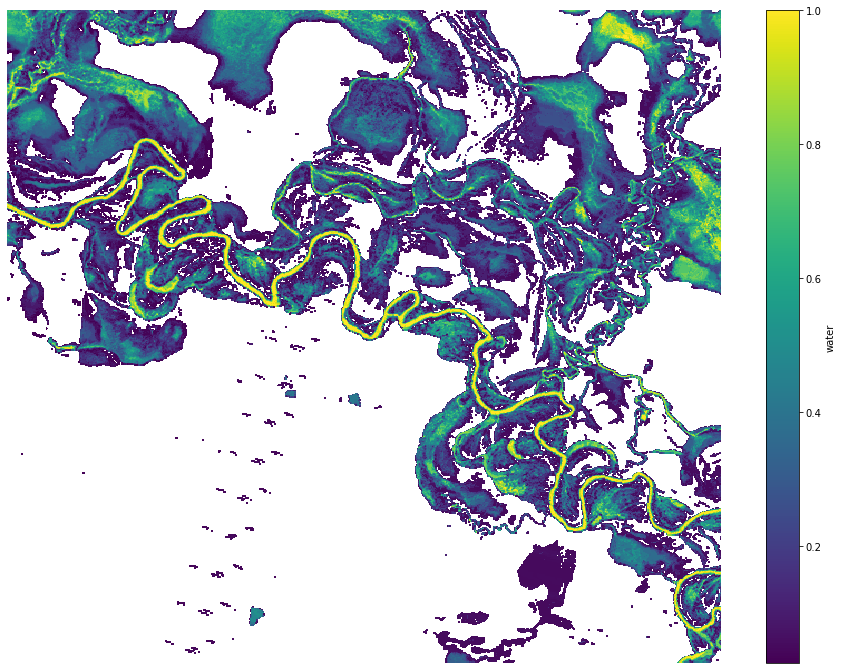

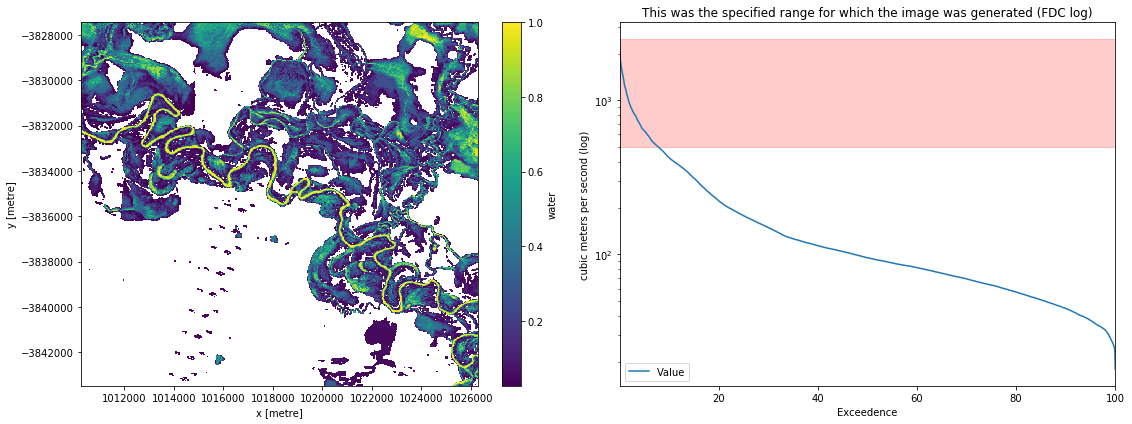

In [7]:
frequency.plot(figsize = (16, 12))
plt.axis('off')

fig, ax = plt.subplots(ncols=2, figsize=(16, 6))

ax1 = frequency.plot(ax=ax[0])

ax2 = gauge_data.plot(x='Exceedence', y='Value', ax=ax[1]) 
ax2 = plt.axhspan(yaxis_lower_parameter, yaxis_higher_parameter, color='red', alpha=0.2)
ax2 = plt.title('This was the specified range for which the image was generated (FDC log)')
ax2 = plt.ylabel('cubic meters per second (log)')
ax2 = plt.xlabel('Exceedence')
ax2 = pyplot.yscale('log')

plt.tight_layout()

Nice, this is the image of the lat and lon you selected based on the duration curve parameters of the gauge you specified. Yellow means it was wet in every pass at that gauge range and purple means it was wet in less that 20% of passes. You can easily go back and change the duration curve parameters to a lower flow if you like. Since the code is quite fast to run it is relatively easy to generate a series of images from lowest flow to highest flow and watch where the water tends to go as the flow rate or water level increases. 